C:\Users\Sailesh\AppData\Local\Temp\ipykernel_19080\1790798605.py:10: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.csv', parse_dates={'datetime': ['Date', 'Time']})
C:\Users\Sailesh\AppData\Local\Temp\ipykernel_19080\1790798605.py:10: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.csv', parse_dates={'datetime': ['Date', 'Time']})
C:\Users\Sailesh\AppData\Local\Temp\ipykernel_19080\1790798605.py:10: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.csv', parse_dates={'datetime': ['Date', 'Time']})
C:\Users\Sailesh\AppData\Local\Temp\ipykernel_19080\1

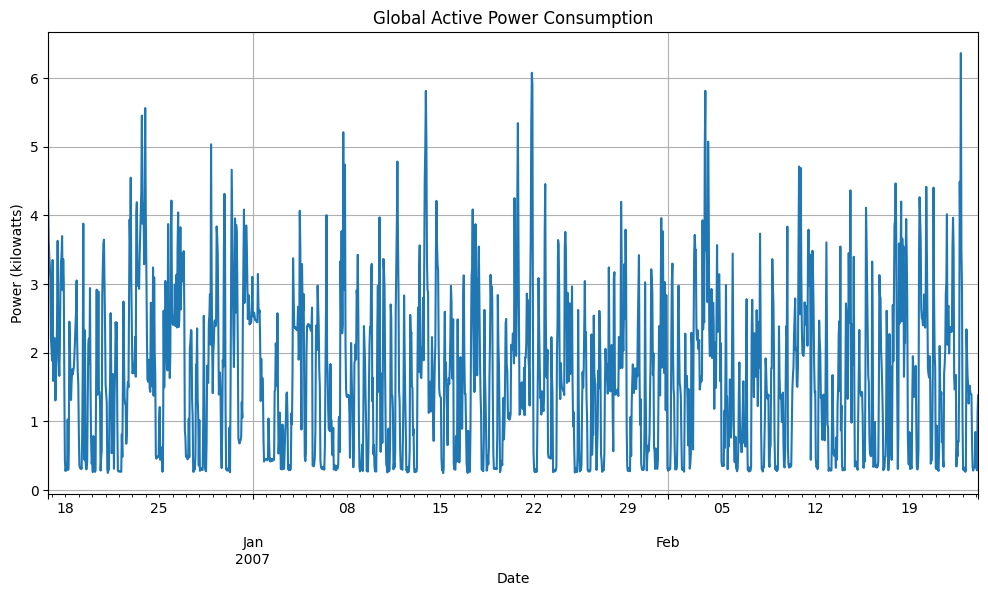

Original series:
ADF Statistic: -6.953787687048206
p-value: 9.543328317236024e-10
Critical Values: {'1%': -3.4343387651403106, '5%': -2.8633018108486343, '10%': -2.5677079480625067}
Data is stationary

After first differencing:
ADF Statistic: -11.8011973346838
p-value: 9.322075077014348e-22
Critical Values: {'1%': -3.4343387651403106, '5%': -2.8633018108486343, '10%': -2.5677079480625067}
Data is stationary

After seasonal differencing (24 hours):
ADF Statistic: -9.439046059776928
p-value: 4.951543528743098e-16
Critical Values: {'1%': -3.4343980252647994, '5%': -2.863327967926724, '10%': -2.567721876448667}
Data is stationary


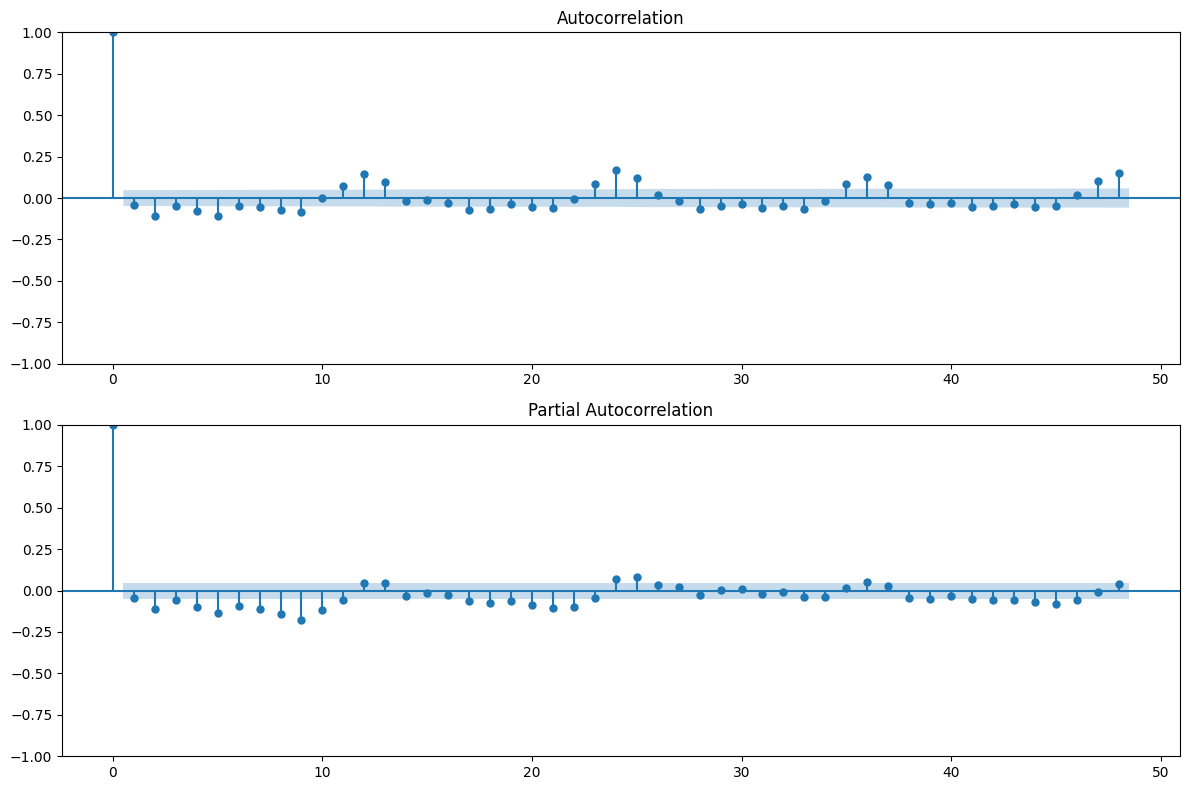

                                      SARIMAX Results                                       
Dep. Variable:                  Global_active_power   No. Observations:                 1334
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               -1389.882
Date:                              Tue, 06 May 2025   AIC                           2793.764
Time:                                      12:47:35   BIC                           2829.857
Sample:                                  12-16-2006   HQIC                          2807.316
                                       - 02-10-2007                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0272      0.330      0.082      0.934      -0.619       0.674
ar.L2          0.48

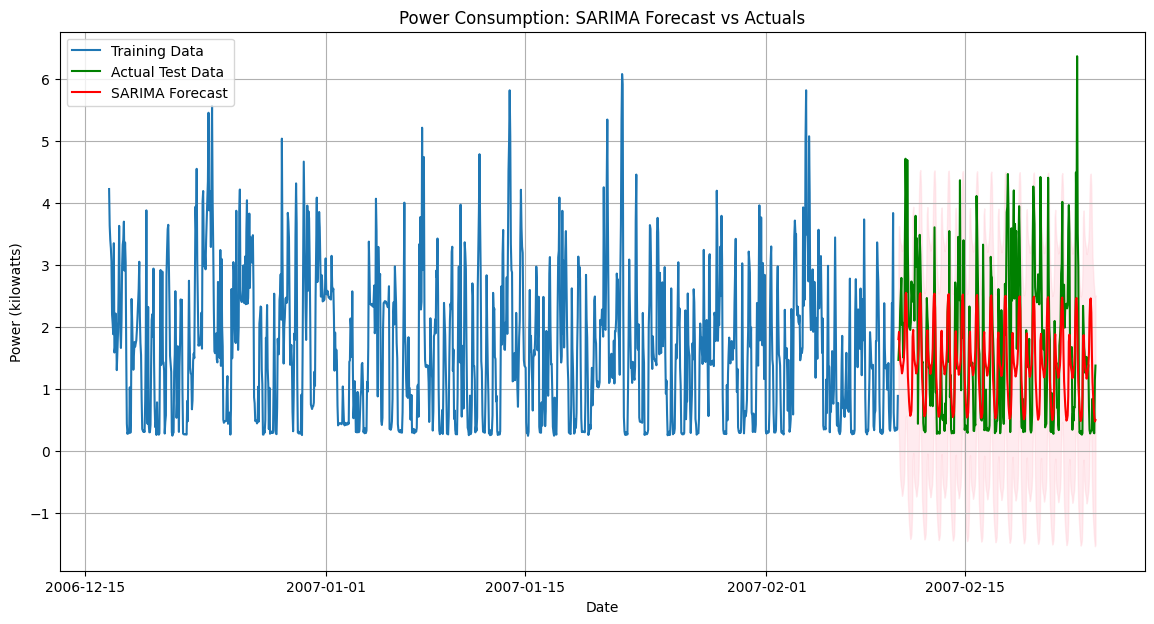

RMSE: 1.09


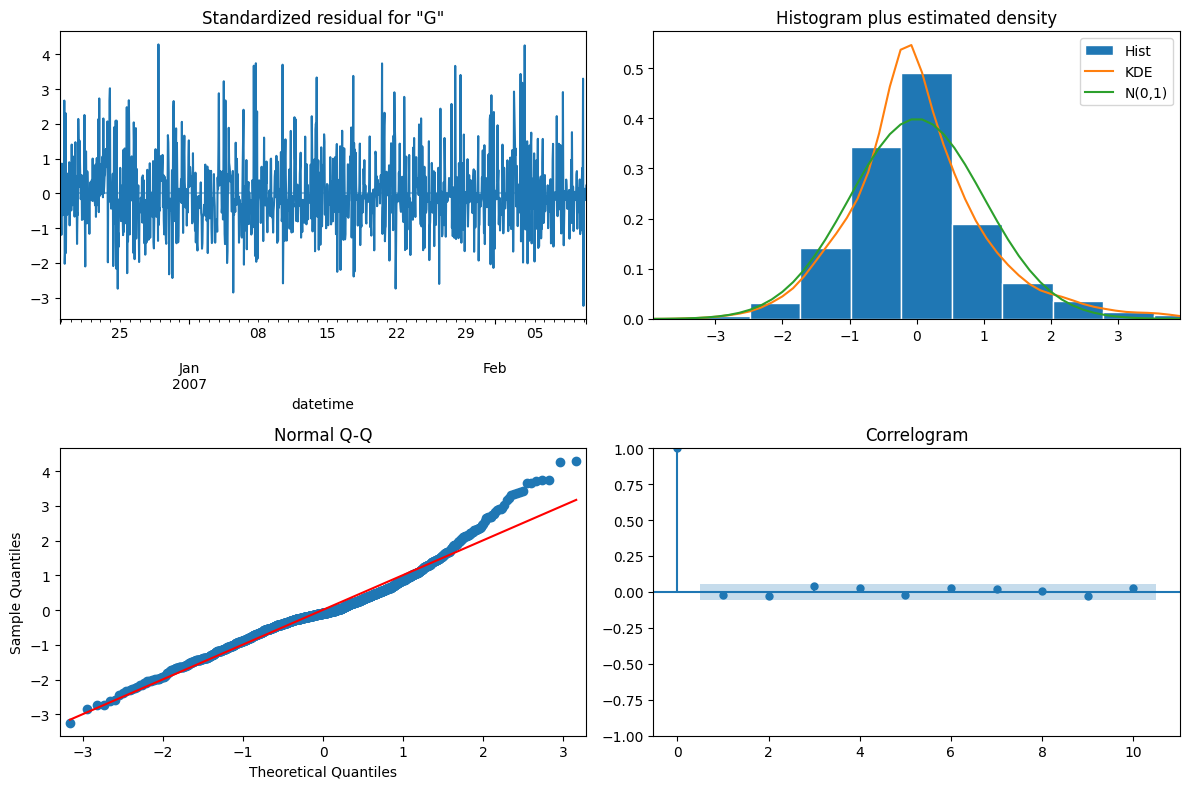

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

df = pd.read_csv('household_power_consumption.csv', parse_dates={'datetime': ['Date', 'Time']})
df = df.set_index('datetime')

df = df.head(100000)

df = df[['Global_active_power']].dropna()

df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna()

df = df.resample('H').mean()

plt.figure(figsize=(12, 6))
df['Global_active_power'].plot(title='Global Active Power Consumption')
plt.xlabel('Date')
plt.ylabel('Power (kilowatts)')
plt.grid(True)
plt.show()

def check_stationarity(series):
    series_clean = series.dropna()
    result = adfuller(series_clean)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")

print("Original series:")
check_stationarity(df['Global_active_power'])

df['power_diff'] = df['Global_active_power'].diff()
print("\nAfter first differencing:")
check_stationarity(df['power_diff'])

df['power_seasonal_diff'] = df['Global_active_power'].diff(24)
print("\nAfter seasonal differencing (24 hours):")
check_stationarity(df['power_seasonal_diff'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['power_diff'].dropna(), lags=48, ax=ax1)
plot_pacf(df['power_diff'].dropna(), lags=48, ax=ax2)
plt.tight_layout()
plt.show()

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

order = (2, 1, 2)
seasonal_order = (1, 1, 1, 24)

model = SARIMAX(train['Global_active_power'], 
                order=order, 
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Training Data')
plt.plot(test.index, test['Global_active_power'], label='Actual Test Data', color='green')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='red')
plt.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], 
                color='pink', alpha=0.3)
plt.title('Power Consumption: SARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Power (kilowatts)')
plt.legend()
plt.grid(True)
plt.show()

rmse = np.sqrt(mean_squared_error(test['Global_active_power'], forecast_mean))
print(f'RMSE: {rmse:.2f}')

results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

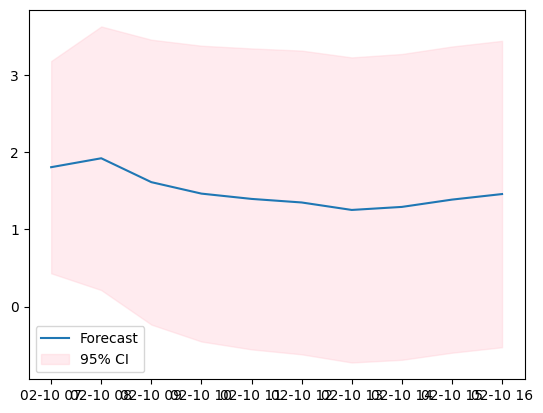

In [2]:
forecast_obj = results.get_forecast(steps=10)
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Plot with confidence intervals
import matplotlib.pyplot as plt
plt.plot(forecast_mean, label='Forecast')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% CI')
plt.legend()
plt.show()
